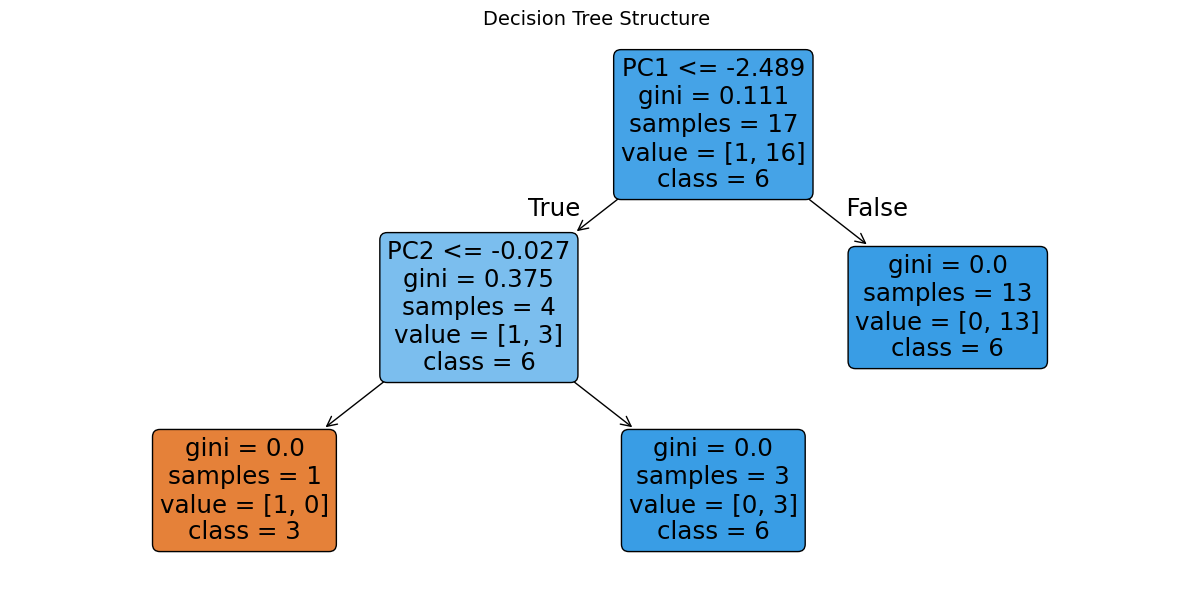

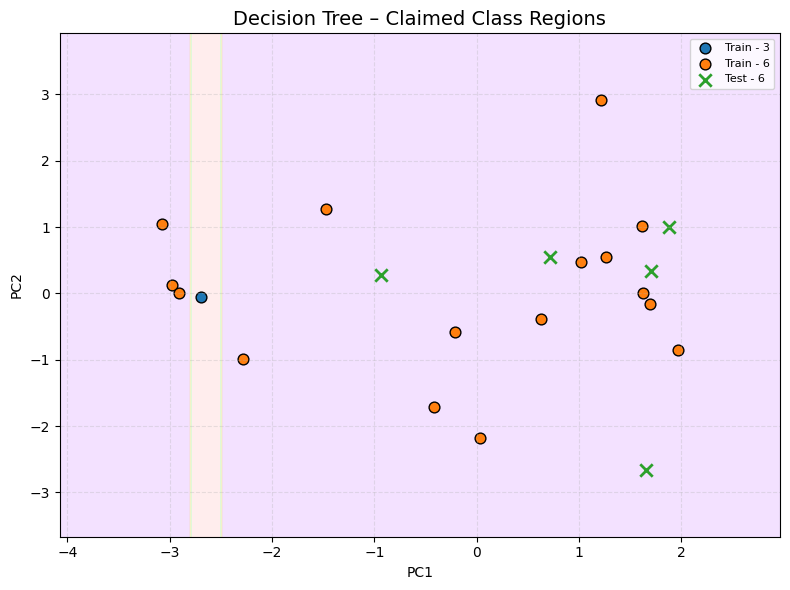

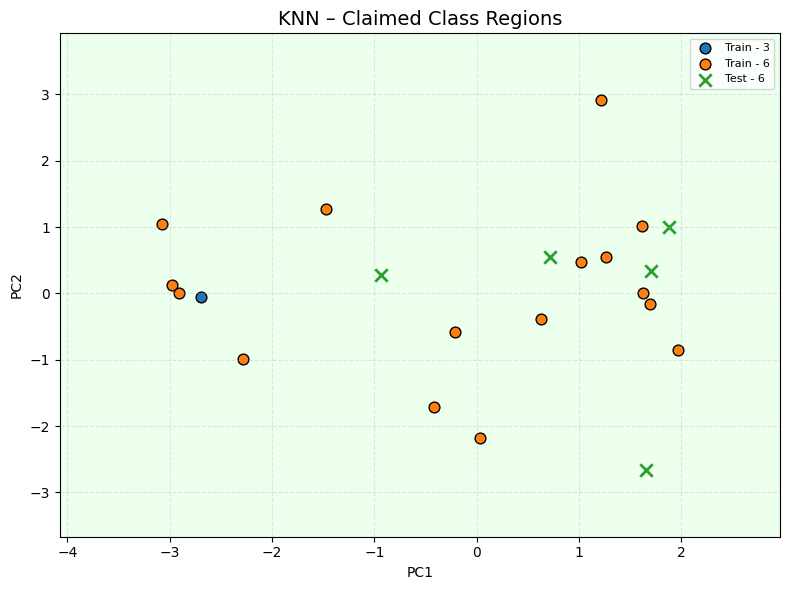

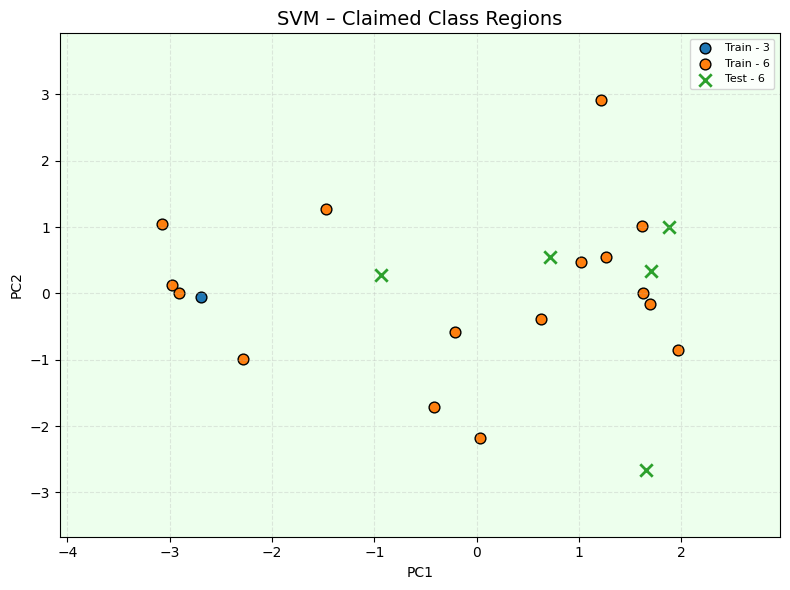

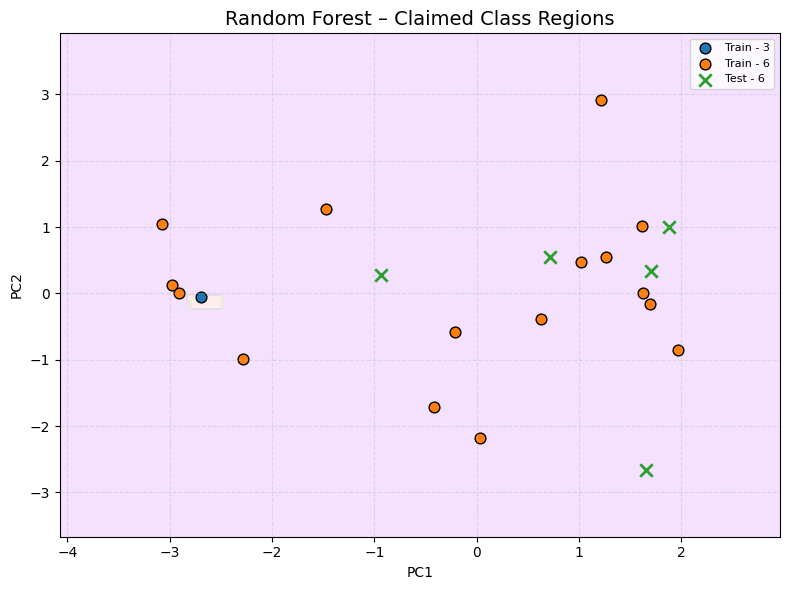

,Model,Training Accuracy
0,Decision Tree,1.000000
1,KNN,0.941200
2,SVM,0.941200
3,Random Forest,1.000000


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap

# --- Load dataset ---
folder_path = "./harth"
data_rows = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        try:
            df = pd.read_csv(os.path.join(folder_path, filename))
            if 'label' not in df.columns:
                continue
            row = df.select_dtypes(include=[np.number]).mean().to_dict()
            row['label'] = df['label'].iloc[0]
            data_rows.append(row)
        except:
            continue

df_all = pd.DataFrame(data_rows)

# --- Preprocess features and labels ---
X = df_all.drop(columns=['label']).fillna(df_all.mean(numeric_only=True))
y = df_all['label']
X_z = X.apply(zscore).dropna(axis=1)

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# --- PCA to 2D for visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_z)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_enc, test_size=0.2, random_state=42)

# --- Meshgrid for plotting ---
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))

# --- Define models ---
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=4),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier()
}

# --- 1. Plot the Decision Tree structure (compact) ---
dtree = models["Decision Tree"]
dtree.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(
    dtree,
    feature_names=["PC1", "PC2"],
    class_names=[str(c) for c in class_names],
    filled=True,
    rounded=True,
    proportion=False
)
plt.title("Decision Tree Structure", fontsize=14)
plt.tight_layout(pad=1.0)
plt.show()

# --- 2. Plot claimed class regions per model ---
claim_cmap = ListedColormap(['#FFCCCC', '#CCFFCC', '#CCCCFF', '#FFF6AA', '#DDAAFF'])

for name, model in models.items():
    model.fit(X_train, y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=claim_cmap, alpha=0.35)

    # Training points
    for label in np.unique(y_train):
        idx = np.where(y_train == label)
        plt.scatter(X_train[idx, 0], X_train[idx, 1],
                    label=f"Train - {class_names[label]}",
                    s=60, edgecolor='black')

    # Test points
    for label in np.unique(y_test):
        idx = np.where(y_test == label)
        plt.scatter(X_test[idx, 0], X_test[idx, 1],
                    marker='x', s=80,
                    label=f"Test - {class_names[label]}", linewidth=2)

    plt.title(f"{name} – Claimed Class Regions", fontsize=14)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- 3. Show raw accuracy table (plain numbers only) ---
results = []
for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    results.append({
        "Model": name,
        "Training Accuracy": round(train_acc, 6)
    })

results_df = pd.DataFrame(results)
display(results_df)
